# 03 Q-agent hyperparameters analysis

#### RL agents are extremely sensitive to hyper-parameters.

In [32]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/mariavogli/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Environment 🌎

In [33]:
import gym
env = gym.make("Taxi-v3").env

In [34]:
from typing import Tuple, List, Any
import random
from pdb import set_trace as stop

import numpy as np
from tqdm import tqdm


def train(
    agent,
    env,
    n_episodes: int,
    epsilon: float
) -> Tuple[Any, List, List]:
    """
    Trains and agent and returns 3 things:
    - agent object
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)

    return agent, timesteps_per_episode, penalties_per_episode


def evaluate(
    agent,
    env,
    n_episodes: int,
    epsilon: float,
    initial_state: int = None
) -> Tuple[List, List]:
    """
    Tests agent performance in random `n_episodes`.

    It returns:
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []
    frames_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        if initial_state:
            # init the environment at 'initial_state'
            state = initial_state
            env.s = initial_state
        else:
            # random starting state
            state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        frames = []
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
        frames_per_episode.append(frames)

    return timesteps_per_episode, penalties_per_episode, frames_per_episode


def train_many_runs(
    agent,
    env,
    n_episodes: int,
    epsilon: float,
    n_runs: int,
) -> Tuple[List, List]:
    """
    Calls 'train' many times, stores results and averages them out.
    """
    timesteps = np.zeros(shape=(n_runs, n_episodes))
    penalties = np.zeros(shape=(n_runs, n_episodes))

    for i in range(0, n_runs):

        agent.reset()

        _, timesteps[i, :], penalties[i, :] = train(
            agent, env, n_episodes, epsilon
        )
    timesteps = np.mean(timesteps, axis=0).tolist()
    penalties = np.mean(penalties, axis=0).tolist()

    return timesteps, penalties

if __name__ == '__main__':

    import gym
    

    env = gym.make("Taxi-v3").env
    alpha = 0.1
    gamma = 0.6
    agent = QAgent(env, alpha, gamma)

    agent, _, _ = train(
        agent, env, n_episodes=10000, epsilon=0.10)

    timesteps_per_episode, penalties_per_episode, _ = evaluate(
        agent, env, n_episodes=100, epsilon=0.05
    )

    print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
    print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1813.06it/s]

Avg steps to complete ride: 20.8
Avg penalties to complete ride: 0.32


In [35]:
import numpy as np
from pdb import set_trace as stop

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

        # hyper-parameters
        self.alpha = alpha
        self.gamma = gamma

    def get_action(self, state):
        """"""
        # stop()
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value

    def reset(self):
        """
        Sets q-values to zeros, which essentially means the agent does not know
        anything
        """
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])

## Q-agent 🤖🧠

In [36]:

# definition in every notebook, don't you think?


# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alphas = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]

## Training loop 🎡

In [37]:
import pandas as pd


# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1
n_episodes = 1000

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties = train(agent,
                                        env,
                                        n_episodes,
                                        epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

alpha: 0.01, gamma: 0.1


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.27it/s]


alpha: 0.01, gamma: 0.6


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.49it/s]


alpha: 0.01, gamma: 0.9


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 212.36it/s]


alpha: 0.1, gamma: 0.1


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 289.90it/s]


alpha: 0.1, gamma: 0.6


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 641.54it/s]


alpha: 0.1, gamma: 0.9


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 831.19it/s]


alpha: 1, gamma: 0.1


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2278.16it/s]


alpha: 1, gamma: 0.6


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2344.03it/s]


alpha: 1, gamma: 0.9


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2327.59it/s]


/Users/mariavogli/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='episode', ylabel='timesteps'>

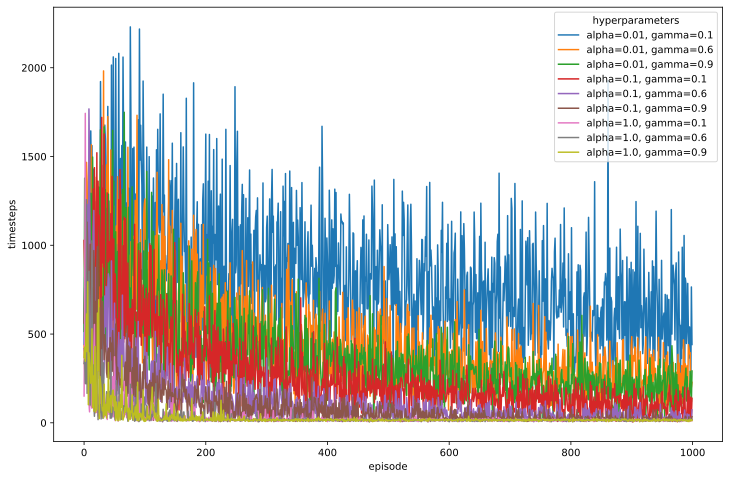

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps',
             hue='hyperparameters', data=results)

## That looks cool! 😎 But a bit too noisy... 😵‍💫
## What about averaging over several runs?

In [39]:


alphas = [0.1, 1]
gammas = [0.1, 0.6, 0.9]

epsilon = 0.1
n_episodes = 1000
n_runs = 10

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        timesteps, penalties = train_many_runs(agent,
                                               env,
                                               n_episodes,
                                               epsilon,
                                               n_runs)
        
        # collect timesteps and penalties for this pair of
        # hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])]

alpha: 0.1, gamma: 0.1


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 288.70it/s]


alpha: 0.1, gamma: 0.6


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 653.02it/s]


alpha: 0.1, gamma: 0.9


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 827.08it/s]


alpha: 1, gamma: 0.1


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2271.81it/s]


alpha: 1, gamma: 0.6


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2279.76it/s]


alpha: 1, gamma: 0.9


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2304.71it/s]


/Users/mariavogli/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='episode', ylabel='timesteps'>

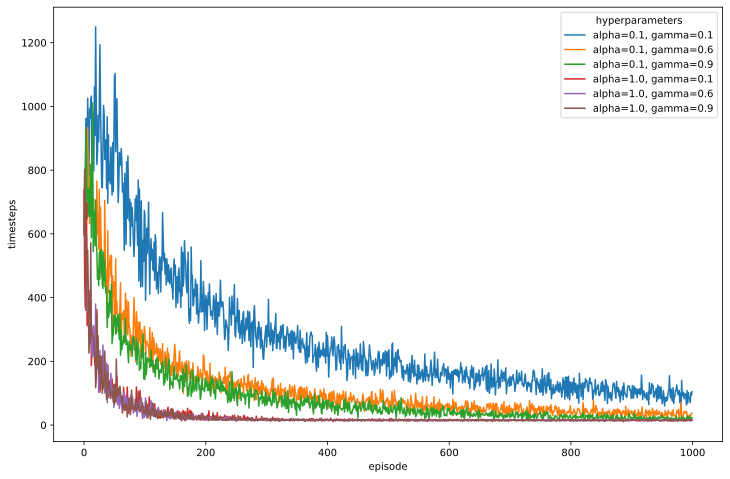

In [40]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='hyperparameters', data=results)

### Nice one!

## What about `epsilon`? Is the current value of 10% the best?

In [30]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    timesteps, penalties = train_many_runs(agent,
                                           env,
                                           n_episodes,
                                           epsilon,
                                           n_runs)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 846.56it/s]


epsilon: 0.1


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 836.31it/s]


epsilon: 0.9


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 192.20it/s]


/Users/mariavogli/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


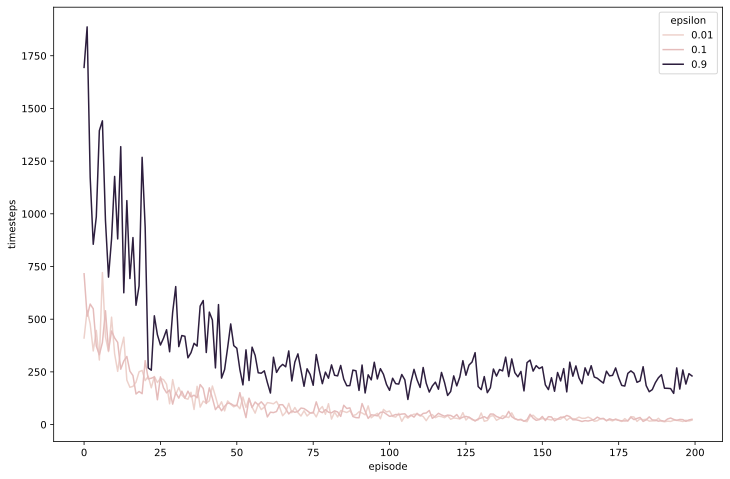

/Users/mariavogli/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='episode', ylabel='penalties'>

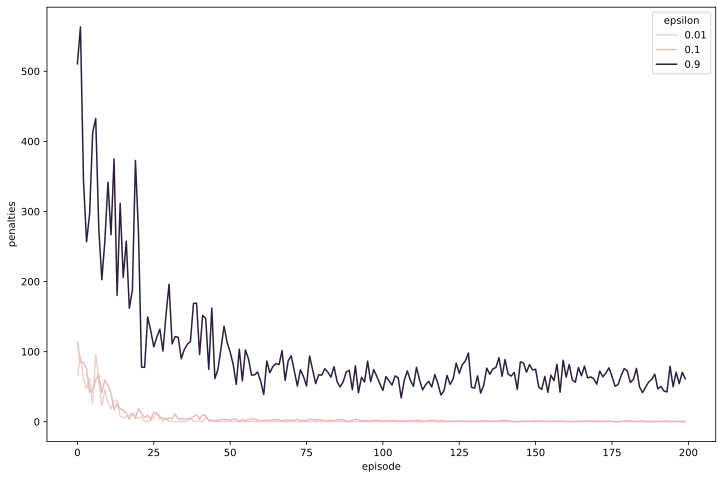

In [31]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)